**Перевод на русский:**

<img style="float:right; max-width:300px" src="imgs/time series.jpg" width="60%" />

# Анализ временных рядов
Временной ряд представляет собой набор наблюдений $x_t$, упорядоченных по времени. Исходя из независимой переменной $x$, представляющей время, мы хотим предсказать зависимую переменную $y$. В отличие от прежней линейной регрессии, данные не являются линейными, и мы хотим использовать информацию о предыдущих наблюдениях ($y_t$ не зависит только от текущего $x_t$, но также от предыдущих наблюдений $x_{t-1}$, ...). Мы предсказываем точки за пределами известного диапазона, поэтому используем экстраполяцию.

Для начала загружаем необходимые пакеты и набор данных:

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import statsmodels.api as sm

matplotlib.rcParams['figure.figsize'] = (8, 4)
sb.set(font_scale=1.)

df = pd.read_csv('data/airline-passengers.csv', sep=',')
print(df.dtypes)
df.head()

In [ ]:
Month         object
Passengers     int64
dtype: object

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Month</th>
      <th>Passengers</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1949-01</td>
      <td>112</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1949-02</td>
      <td>118</td>
    </tr>
    <tr>
      <th>2</th>
      <td>1949-03</td>
      <td>132</td>
    </tr>
    <tr>
      <th>3</th>
      <td>1949-04</td>
      <td>129</td>
    </tr>
    <tr>
      <th>4</th>
      <td>1949-05</td>
      <td>121</td>
    </tr>
  </tbody>
</table>
</div>

Преобразуем столбец Month из типа object в тип datetime и устанавливаем его в качестве индекса (для удобства манипуляции данными). Затем выделяем время (в месяцах) в независимую переменную $x$, а количество пассажиров, перевезенных в каждом месяце, в зависимую переменную $y$

In [ ]:
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month')

df.plot();
# эквивалентно:
x, y = df.index, df['Passengers']
plt.plot(x, y); plt.xlabel('Месяцы');


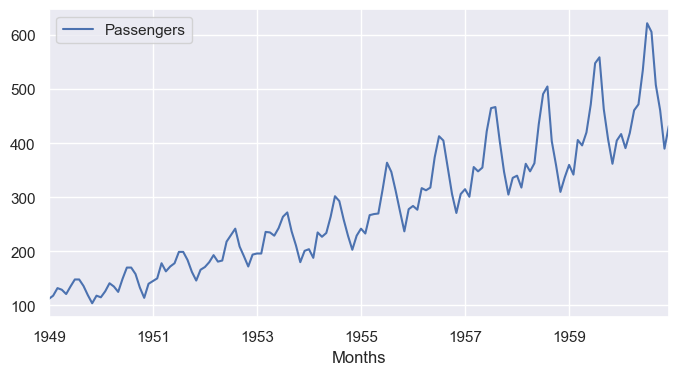

## Автокорреляция
Автокорреляция используется для проверки наличия шаблона в данных.
Чтобы мы могли моделировать временной ряд, должна существовать автокорреляция.
Положительная автокорреляция означает, что значения $y$ уменьшаются (или увеличиваются) вместе, в то время как отрицательная автокорреляция означает, что значения $y$ уменьшаются (или увеличиваются) в противоположном направлении.
Если нет автокорреляции, это означает, что значения меняются случайным образом со временем, и мы не можем найти шаблон в данных ➡️ в этом случае проблему нельзя решить алгоритмами временных рядов.

### Автокорреляционная функция
Автокорреляцию мы анализируем с использованием автокорреляционных графиков.
Автокорреляционная функция (англ. *autocorrelation function* или *ACF*) - это график автокорреляции. Мы используем функцию `plot_acf()`, чтобы построить график.
На оси x - временной интервал $k$ между двумя наблюдениями. На оси y - коэффициент автокорреляции для временного интервала $k$.

Значения внутри затененной области незначительны ➡️ с 95% уверенностью нет автокорреляции для текущего $k$.
Значения вне затененной области значимы, то есть существует автокорреляция (насколько она сильна, говорит коэффициент автокорреляции).
Если на графике у нас получается, что (почти) все значения находятся внутри затененной области ➡️ тогда нет автокорреляции; вероятно, в данных нет шаблона, а данные представляют собой шум.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Passengers'], lags=20)
plt.show()

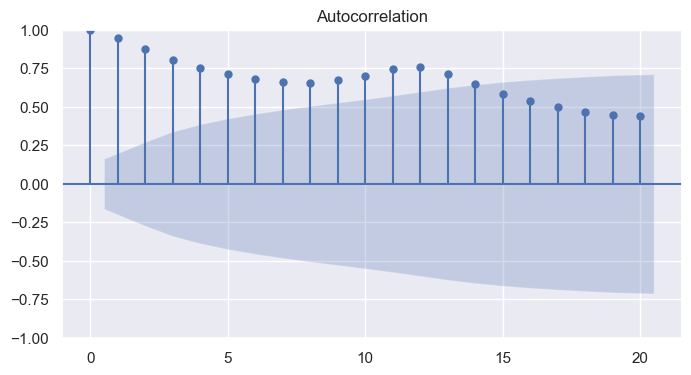

<img style="float:right; max-width:400px" src="imgs/acf_pacf.png" width="60%" />

**Толкование:** На графике мы видим, что после $k=14$ нет автокорреляции; значения незначительны. Высокое значение ACF для $k=2$ указывает на сильное воздействие предыдущего месяца на текущий. Например, если количество пассажиров в январе растет (уменьшается), то количество пассажиров в марте также растет (уменьшается) из-за положительной автокорреляции. На основе количества пассажиров в январе мы можем предсказать количество пассажиров в марте.

Возможно, количество пассажиров в январе не оказывает прямого влияния на март, а влияет на февраль, который влияет на март - это косвенное воздействие.
**Автокорреляция измеряет прямое и косвенное воздействие** предыдущего месяца на текущий.
Однако, если нас интересует прямое воздействие *количества пассажиров в январе* на *количество пассажиров в марте* (мы пропускаем февраль), мы используем *частичную автокорреляцию*.

### Частичная автокорреляция
Автокорреляция измеряет прямое и косвенное воздействие, в то время как частичная автокорреляция измеряет только прямое воздействие (англ. *partial autocorrelation function - PACF*). Чтобы измерить только прямое воздействие, мы используем *PACF*.

**Толкование:** На следующем графике видно, что только несколько значений для $k$ имеют большое значение PACF. Для $k=2$ мы наблюдаем значительное значение, но почти на грани, что указывает на относительно слабое прямое воздействие предыдущего месяца на текущий месяц.

**ACF vs PACF:** Учитывая высокое значение ACF для $k=2$ и более низкое значение PACF ➡️ предыдущий месяц имеет сильное косвенное, но слабое прямое воздействие на количество пассажиров в текущем месяце. Высокое значение ACF для $k=2$ подразумевает, что мы можем предсказывать количество пассажиров в марте, зная количество пассажиров в январе и феврале. С другой стороны, значительное значение PACF для $k=2$ указывает на то, что мы можем предсказывать количество пассажиров в марте на основе количества пассажиров в январе (мы пропускаем февраль). Однако, учитывая, что значение PACF находится на грани, прогнозы для марта только на основе января будут менее точными.

**PACF для анализа vs PACF для прогнозирования:**
PACF мы применяем к нестационарным данным (объяснено ниже) **для анализа** временного ряда. Нестационарные данные имеют компоненты (тренд и сезонность), которые косвенно влияют на значения PACF. PACF не устраняет это косвенное воздействие компонент.
Мы также будем использовать график PACF в контексте **прогнозирования модели** (мы работаем в следующем термине), и тогда мы будем использовать PACF с учетом стационарных данных, и значения коэффициентов будут различными (PACF для нестационарных данных имеет другие значения, чем PACF для стационарных данных).



In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['Passengers'], lags=20)
plt.show()

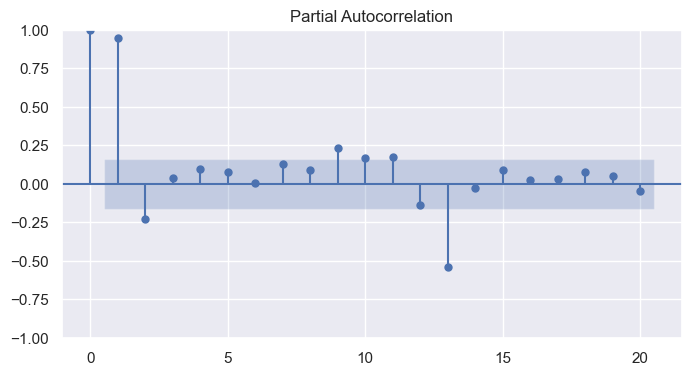

<img style="float:right; max-width:400px" src="imgs/components.jpg" width="60%" />

### Компоненты временного ряда
Временной ряд состоит из нескольких компонентов (компоненты - это шаблоны, которые влияют на поведение временного ряда).
4 основные компоненты: **тренд, сезонность, цикличность и остатки (шум)**.
Чтобы проанализировать временной ряд, его необходимо разбить на компоненты.
*Примечание: цикличность не проявляется в регулярных интервалах, и ее форма неоднородна, в отличие от сезонности, что затрудняет ее выделение в отдельную компоненту. Поэтому часто мы выделяем ее внутри тренда, а не как отдельную компоненту.*

Чтобы разделить ряд на компоненты, нам нужно знать, каким образом ряд состоит из компонентов, то есть как эти компоненты взаимодействуют друг с другом. Способ взаимодействия компонентов может быть:
- аддитивная модель
    - данные получаются как сумма компонентов: $𝑌_𝑡=𝑇_𝑡+𝑆_𝑡+𝐶_𝑡+𝑅_𝑡$.
    - Амплитуда сезонности, цикличности и шума не зависит от тренда.
- мультипликативная модель
    - данные получаются как произведение компонентов: $𝑌_𝑡=𝑇_𝑡∗𝑆_𝑡∗𝐶_𝑡∗𝑅_𝑡$.
    - Амплитуда сезонности, цикличности и шума зависит от тренда.

<img style="float:right; max-width:400px" src="imgs/additive vs multiplicative.png" width="60%" />

Какая модель лучше описывает данные, мы определяем с помощью графиков, как показано на рисунке справа.

### Метод STL
Чтобы разделить временной ряд на компоненты, мы используем метод **STL** (*Seasonal-Trend decomposition using LOESS*). Метод **STL** требует аддитивной модели.

В нашем примере с числом пассажиров мы видим на графиках временного ряда, что амплитуда компонент изменяется с изменением тренда, поэтому мы предполагаем, что у нас есть *мультипликативная модель*. Тем не менее, метод **STL** требует аддитивной модели, поэтому необходимо преобразовать данные в аддитивную модель. Мультипликативную модель можно преобразовать в аддитивную с использованием логарифмирования: $log(𝑌_𝑡 )=log(𝑇_𝑡 )+log(𝑆_𝑡 )+log(𝐶_𝑡 )+log(𝑅_𝑡)$. *Примечание: логарифмирование также используется, когда данные имеют экспоненциальный тренд, который не очевиден.*

In [ ]:
df['log10(Passengers)'] = np.log10(df['Passengers'])
df['log10(Passengers)'].plot();

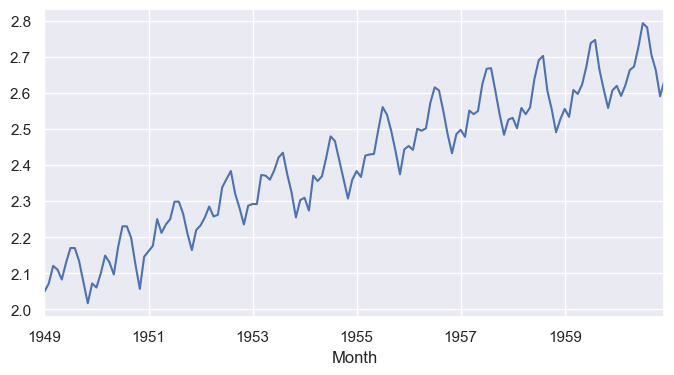

Логарифмированием мы получили новые данные, в которых амплитуда сезонности, цикличности и шума не зависит от тренда ➡️ мы получили аддитивную модель. Теперь мы применяем метод STL, чтобы разделить временной ряд на компоненты:


In [ ]:
from statsmodels.tsa.seasonal import STL

# Применяем метод STL для временного ряда, логарифмированного базе 10
stl = STL(df['log10(Passengers)']).fit()

# Визуализируем разложение на компоненты
stl.plot()
plt.show()

# Мы также можем получить компоненты напрямую
# trend - тренд, seasonal - сезонность, resid - остатки
trend, seasonal, resid = stl.trend, stl.seasonal, stl.resid



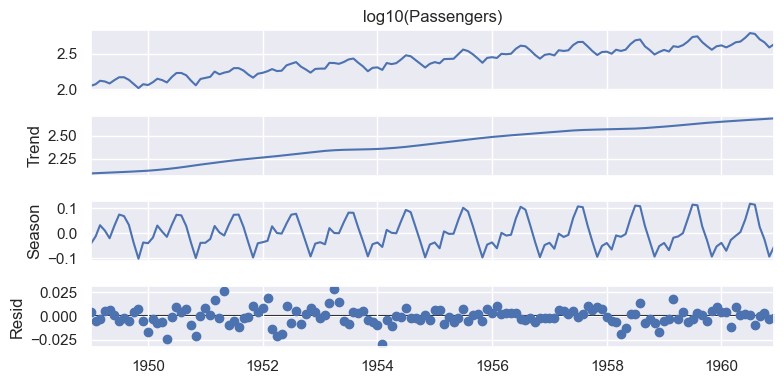

**Интерпретация:** Применением метода STL мы разделили временной ряд на компоненты и видим, что в данных присутствуют тренд и сезонность.

<img style="float:right; max-width:400px" src="imgs/stationarity.png" width="40%" />

## Стационарность
Распределение описывает статистические характеристики (например, **среднее, дисперсия и ковариация**). Распределение не меняется со временем, когда указанные статистические характеристики постоянны. Стационарность означает, что распределение не меняется со временем, то есть статистические характеристики постоянны. Для прогностических моделей (которые мы разрабатываем далее) необходимо, чтобы данные были стационарными. Большинство моделей и методик требуют стационарный временной ряд. Если временной ряд не стационарен, его необходимо преобразовать, чтобы достичь стационарности.

Для проверки стационарности мы используем ADF-тест (*расширенный тест Дики-Фуллера*). С точностью 95% (p-значение ≤ 0.05) мы утверждаем, что временной ряд является стационарным, когда ADF ≤ -2.862. Вместо значения ADF мы также можем использовать p-значение. Если конкретное значение `p-значение ≤ 0.05` => мы на 95% уверены, что временной ряд стационарен ✅.

В нашем примере с числом пассажиров временной ряд нестационарен. Мы проверим стационарность с использованием ADF-теста далее, где видим, что p-значение большое, и мы не получили стационарный временной ряд.

In [ ]:
df['Passengers'].plot();
from statsmodels.tsa.stattools import adfuller
adf_value = adfuller(df['Passengers'])[0] 
p_value = adfuller(df['Passengers'])[1]
print(f'{adf_value=:.2f}, {p_value=:.2f}')

if p_value <= 0.05: print('существует стационарность')
else: print('стационарность отсутствует')


adf_value=0.82, p_value=0.99
ne postoji stacionarnost


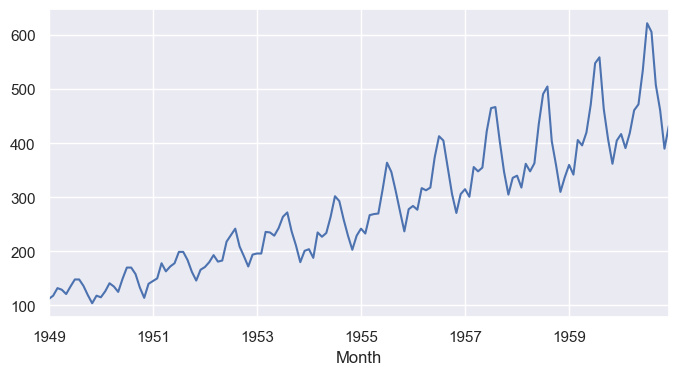

### Достижение стационарности
- Среднее решается: 1. удалением тренда или 2. дифференцированием.  
- Дисперсию и ковариацию решаем: 1. удалением сезонности или 2. дифференцированием или 3. логарифмированием.

*Дифференцирование - нахождение производной для временного ряда.*

Наш временной ряд имеет все 3 проблемы. Для их решения мы начнем с логарифмирования данных (мы уже сделали это перед применением метода STL). С графика видим, что мы решили проблему дисперсии и ковариации (почти полностью постоянная), что отлично ✅.
Хотя стационарность еще не достигнута, мы видим, что p-значение уменьшилось, что означает, что мы на правильном пути.

In [ ]:
stationary_data = df['log10(Passengers)'].copy() # глубокая копия, чтобы не изменять столбец
plt.plot(stationary_data);

adf_value = adfuller(df['log10(Passengers)'])[0] 
p_value = adfuller(df['log10(Passengers)'])[1]
print(f'{adf_value=:.2f}, {p_value=:.2f}')

if p_value <= 0.05: print('существует стационарность')
else: print('стационарность отсутствует')


adf_value=-1.72, p_value=0.42
ne postoji stacionarnos


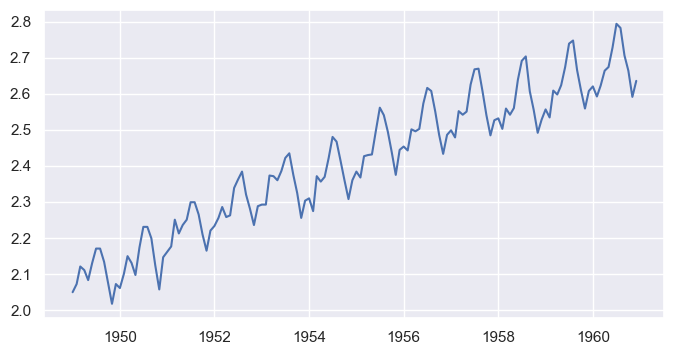


Похоже, что логарифмирование решило две проблемы стационарности - дисперсию и ковариацию.
Нам всё ещё не хватает постоянного среднего значения для достижения стационарности, что мы можем решить удалением тренда или дифференцированием.

In [ ]:
# 1. метод - убираем тренд
stacionarni_podaci = df['log10(Passengers)'] - trend
p_vrednost = adfuller(stacionarni_podaci)[1]
print(f'{p_vrednost=:.2f}')
if p_vrednost <= 0.05: print('присутствует стационарность')
else: print('нет стационарности')
plt.plot(stacionarni_podaci);

p_value=0.03
postoji stacionarnost

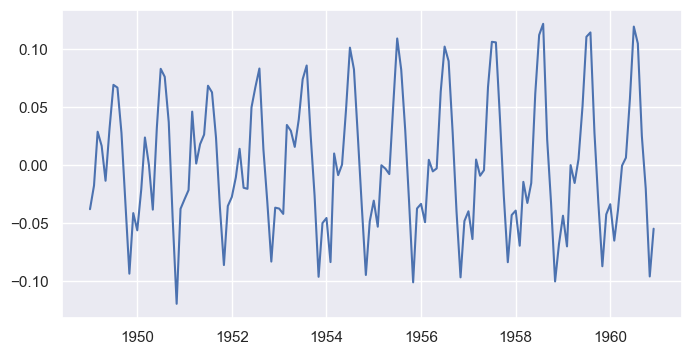

Удаление тренда решило проблему со средним значением, и мы получили стационарность. Теперь мы попробуем решить среднее значение другим способом - дифференцированием.

In [ ]:
# 2. способ - дифференцирование, вызов функции `diff()`
stationary_data = df['log10(Passengers)'].diff().dropna()
p_value = adfuller(stationary_data)[1]
print(f'{p_value=:.2f}')
if p_value <= 0.05: print('есть стационарность')
else: print('нет стационарности')
plt.plot(stationary_data);

p_value=0.07
ne postoji stacionarnost

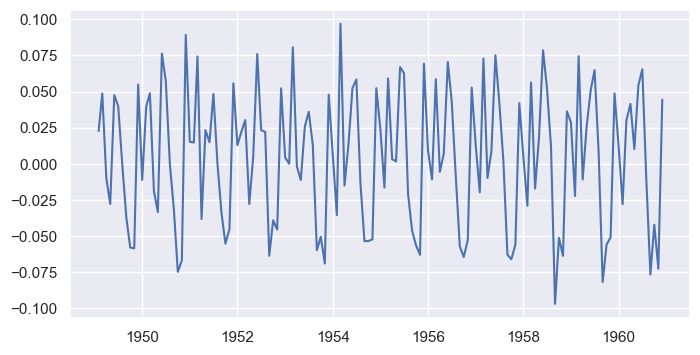

Хотя p-значение очень близко к порогу 5%, в настоящее время стационарности еще нет после дифференциации, потому что оно не опускается ниже порога. Мы можем применить дифференциацию еще раз:

*Примечание: на практике обычно не рекомендуется дифференцировать более 3 раз, так как это может привести к потере множества данных.*

In [ ]:
# 2. способ - дважды применяем дифференциацию `diff().diff()`
stationary_data = df['log10(Passengers)'].diff().diff().dropna()
p_value = adfuller(stationary_data)[1]
print(f'{p_value=:.2f}')
if p_value <= 0.05: print('стационарность присутствует')
else: print('стационарности нет')
plt.plot(stationary_data);

p_value=0.00
postoji stacionarnost


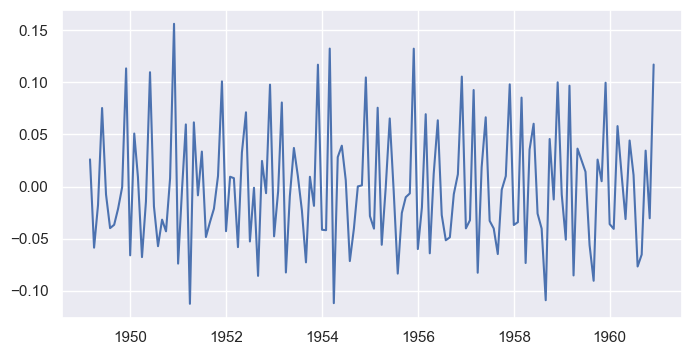

# Задачи
**TODO 1**: Загрузите временной ряд для количества пассажиров, используя [data/airline-passengers.csv] и выберите данные с 1954 по 1960 год (не включая даты из 1960 года). Затем:
1. Постройте график временного ряда.
2. Определите, могут ли данные быть моделированы как временной ряд.
3. Определите, какие предыдущие месяцы имеют прямое воздействие на текущий.
4. Разделите временной ряд на компоненты и постройте график компонентов.
5. Восстановите и постройте оригинальный временной ряд, используя только данные о тренде, сезонности и шуме.
6. Достигните стационарности с уверенностью в 99%, не используя дифференцирование.